# Tool for the calculation of the mass balance gradient 

## Imports

In [71]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as stm
import pylab

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

## Functions
Two functions, that eliminate nan (no data) values from a given dataset

In [72]:
def filter_nan(data):
    return [x for x in data if str(x) != 'nan']

def clear_nan_hypso(hypso):
    hypso[0] = [ hypso[0][i] for i in range(0, len(hypso[0])) if str(hypso[1][i])!= 'nan' ]
    hypso[1]=[x for x in hypso[1] if str(x)!= 'nan']
    
    return hypso

returns the value of a linear function

In [73]:
def linear_function(slope, intercept, x):
    return x*slope + intercept


interpolates between the datapoints of a hypsometry. Choose 'linear' or 'cubic' as arguments for the kind

In [74]:
def interpolatad_hypso(x_data, y_data):
    return interp1d(x_data, y_data, kind='linear')



returns a normalized factor that represents the uncertainities of measurement points at given elevation


In [75]:
def transform_into_sigma(x):

    return 1/(np.sqrt(x))

fits the data without any weighting linearly

In [76]:
def fit(x_data_fit, x_data,y_data):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,y_data)
    return ( slope, intercept, r_value, p_value, std_err)

combined linear fit: weighted and unweighted as well

In [77]:
def analyse(hypso, data, colour):
    
    # increase size
    plt.rcParams["figure.figsize"] = [15,10]
    #JoG figure reqs: (maximum widths: 85 mm single-column; 179 mm double-column) or 3.34 and 7.04 in
    
    #### The  hypsometry with interpolation #####
    # setting the x-values
    x_data_fit=np.linspace(np.min(data[0]),np.max(data[0]),1000)
    
    # plotting formalities
    plt.subplot(221)
    plt.title('Hypsometry of the glacier')
    plt.xlabel('Elevation [h]')
    plt.ylabel('relative_probability_density')
    plt.grid(True)
    
    # plot the data points
    plt.plot(hypso[0], hypso[1], 'bo', color=colour)
    
    # interpolation
    f1= interpolatad_hypso(hypso[0], hypso[1])
    x_inter=np.linspace(np.min(hypso[0]),np.max(hypso[0]),100)
    plt.plot(x_inter, f1(x_inter), color=colour)

    
    #### plot of relative weightening uncertainities #### 
    
    # plotting formalities
    plt.subplot(223)
    plt.title('Assumed uncertainities')
    plt.xlabel('Elevation [h]')
    plt.ylabel('relative uncertainity')
    plt.grid(True)
    
    # weightening uncertainities
    sigma=transform_into_sigma(f1(data[0]))
    
    # plot the sigma data points
    plt.plot(data[0], sigma, 'bo',color=colour)

    
    #### The actual data and fit ####
    popt, pcov = curve_fit(linear_function, data[0], data[1], sigma=sigma, absolute_sigma=False)

    yfit = [linear_function(popt[1], popt[0], i) for i in data[0]]
    
    # label stuff
    plt.subplot(222)
    plt.title('Data and the two fit curves')
    plt.xlabel('Elevation [m a.s.l.]')
    plt.ylabel('Mass balance [m w.e.]')
    plt.grid(True)
    
    # lines and data points
    plt.plot(data[0], yfit, label='weighted fit', color=colour)
    plt.plot(data[0],data[1],marker='o', linestyle='', color=colour)
    
    unweighted_fit=fit(x_data_fit, data[0],data[1])
    line=unweighted_fit[0]*x_data_fit + unweighted_fit[1]
    plt.plot(x_data_fit, line, linestyle='--', color=colour, label='unweighted fit')
    
    
    #### comparison between the gradients ####
    
    aha = plt.subplot(224)
    plt.title('Both gradients in comparison')
    axes = plt.axes(aha)
    axes.set_xticks([0,1])
    axes.set_xticklabels(['unweighted fit', 'weighted fit'], rotation='horizontal')
    plt.ylabel('gradient')
    plt.bar([0,1], [unweighted_fit[0], popt[1]], align='center',color=colour, yerr=[unweighted_fit[4],np.sqrt(np.diag(pcov))[1]])
    
    print('The MB-gradient (unweighted) is: ', unweighted_fit[0], ' +- ', unweighted_fit[4] ,'\n The MB-gradient (weighted) is: ', popt[1]  ,' +- ' , np.sqrt(np.diag(pcov))[1]   )
    
    
    plt.show()

## Main procedure

Read the data points from csv-file (best way to do it is using pandas)

In [78]:
data_table = pd.read_csv('/home/pelto/Desktop/lidar_cbt_analysis/Ba/all_points_coords.csv')

# if you want to take a look at what is read, remove comment of:
data_table[:5]

,Elevation_c,Ba_c,Bs_c,year_c,E_c,N_c,Elevation_k,Ba_k,year_k,Elevation_n,...,year_n,Elevation_z,Ba_z,year_z,Elevation_i,Ba_i,year_i,Elevation_cc,Ba_cc,year_cc
0,1896,-6.42460,-7.29260,2015,505140.0,5631229.0,2697.0,0.48,2013.0,2206.0,...,2014.0,2102.0,-2.979,2013.0,2011.0,-2.99859,2009.0,2337.0,0.54,2008.0
1,2001,-5.89225,-6.80625,2015,504980.0,5630973.0,2647.0,0.14,2013.0,2430.0,...,2014.0,2121.0,-3.393,2013.0,2065.0,-4.16318,2009.0,1846.0,-3.49,2008.0
2,2101,-5.47820,-6.42220,2015,505201.0,5630611.0,2606.0,0.17,2013.0,2563.0,...,2014.0,2181.0,-2.682,2013.0,2097.0,-3.50294,2009.0,1901.0,-2.70,2008.0
3,2200,-4.01310,-5.37110,2015,505546.0,5629903.0,2541.0,0.00,2013.0,2663.0,...,2014.0,2238.0,-1.503,2013.0,2139.0,-3.30120,2009.0,1960.0,-1.94,2008.0
4,2309,-3.18500,-4.70700,2015,505451.0,5629221.0,2509.0,-0.44,2013.0,2710.0,...,2014.0,2302.0,-1.854,2013.0,2183.0,-3.96144,2009.0,2022.0,-1.94,2008.0


okay, lets put the data in glacier_specific arrays of the structure: (list with elevation data, list with MB data)

In [79]:
conrad_data = [filter_nan(data_table.iloc[ :,0].tolist()),filter_nan(data_table.iloc[ :,1].tolist())]
zillmer_data = [filter_nan(data_table.iloc[ :,12].tolist()),filter_nan(data_table.iloc[ :,13].tolist())]
nordic_data = [filter_nan(data_table.iloc[ :,9].tolist()),filter_nan(data_table.iloc[ :,10].tolist())]
kokanee_data = [filter_nan(data_table.iloc[ :,6].tolist()),filter_nan(data_table.iloc[ :,7].tolist())]
ille_data = [filter_nan(data_table.Elevation_i.tolist()),filter_nan(data_table.Ba_i.tolist())]
castle_data = [filter_nan(data_table.Elevation_cc.tolist()),filter_nan(data_table.Ba_cc.tolist())]

# check the number of data points in each glacier-specific array

print('Number of Data-points: \n Conrad: ', len(conrad_data[0]), '\n Zillmer: ', len(zillmer_data[0]),'\n Nordic: ', len(nordic_data[0]),'\n Kokanee: ', len(kokanee_data[0]),'\n Ille: ', len(ille_data[0]), '\n Castle: ', len(castle_data[0]))

Number of Data-points: 
 Conrad:  113 
 Zillmer:  104 
 Nordic:  68 
 Kokanee:  98 
 Ille:  87 
 Castle:  100


we combine all data for the last plot

In [80]:
combined_x_data=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]+ille_data[0]+castle_data[0]
combined_y_data=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]+ille_data[1]+castle_data[1]

#w/o illec data ---illec SMB lacks measurements over upper 200 m of glacier range, thus potentially biasing SMB grad.
combined_x_data2=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]
combined_y_data2=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]

#w/o castle
combined_x_data3=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]+ille_data[0]
combined_y_data3=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]+ille_data[1]


# filter 'nan' (otherwise we get a lot of errors)
combined_x_data=[x for x in combined_x_data if str(x) != 'nan']
combined_y_data=[x for x in combined_y_data if str(x) != 'nan']

#w/o illec data
combined_x_data=[x for x in combined_x_data if str(x) != 'nan']
combined_y_data=[x for x in combined_y_data if str(x) != 'nan']

## The actual analysis

We start with getting the hypsometries from the csv-file and make plottable datapoints out of them

In [81]:
hypso = pd.read_csv('/home/pelto/Desktop/lidar_cbt_analysis/Ba/Hypsometry/hypsometry_study_glaciers.csv')

hypso_conrad= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,2].tolist()])
hypso_zillmer= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,3].tolist()])
hypso_nordic= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,4].tolist()])
hypso_kokanee= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,6].tolist()])
hypso_ille= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,7].tolist()])
hypso_castle= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,8].tolist()])

### Conrad glacier less west wing obs.

In [82]:
# T =pd.DataFrame()
# for i in range(len(obs.name)):
#     if 'W' not in obs.name[i] and 'w' not in obs.name[i] :
#         T=T.append(obs[obs.index == i],ignore_index=True)
        
# obs = T

In [83]:
# analyse(hypso_conrad, conrad_data, 'blue')

### Conrad glacier

The MB-gradient (unweighted) is:  0.007040103041035048  +-  0.000286631300660269 
 The MB-gradient (weighted) is:  0.0067685832452038215  +-  0.000330015631717006


/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


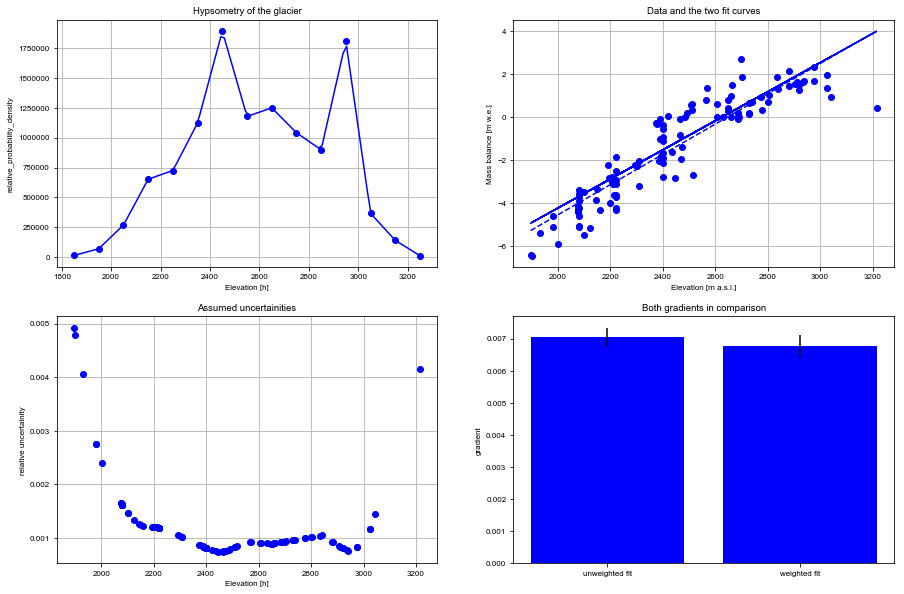

In [84]:
analyse(hypso_conrad, conrad_data, 'blue')

### Zillmer glacier

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


The MB-gradient (unweighted) is:  0.007921875952773941  +-  0.00046821222642323804 
 The MB-gradient (weighted) is:  0.008690488840119474  +-  0.0005486950642815271


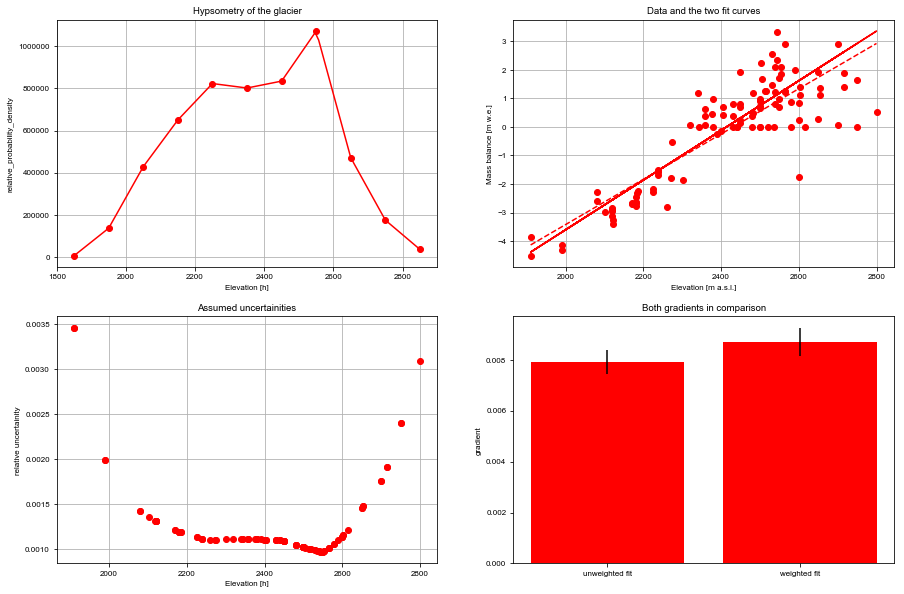

In [85]:
analyse(hypso_zillmer, zillmer_data, 'red')


### Nordic glacier

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


The MB-gradient (unweighted) is:  0.0060100833955718  +-  0.0006621869252084585 
 The MB-gradient (weighted) is:  0.005544449960942486  +-  0.0007540037903002107


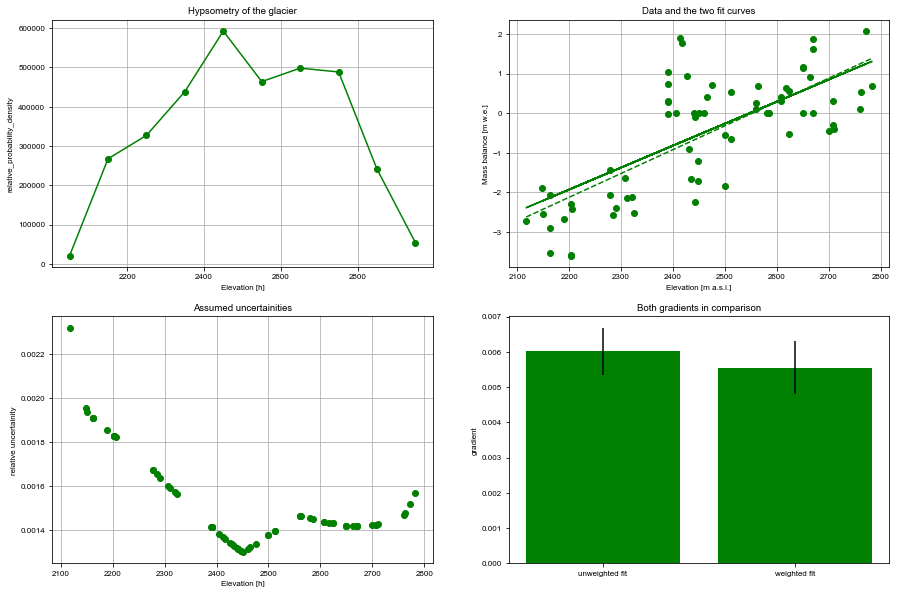

In [86]:
analyse(hypso_nordic, nordic_data, 'green')

### Kokanee glacier

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


The MB-gradient (unweighted) is:  0.006846068741336149  +-  0.0006109907211560216 
 The MB-gradient (weighted) is:  0.006241867181099496  +-  0.0007462505807053028


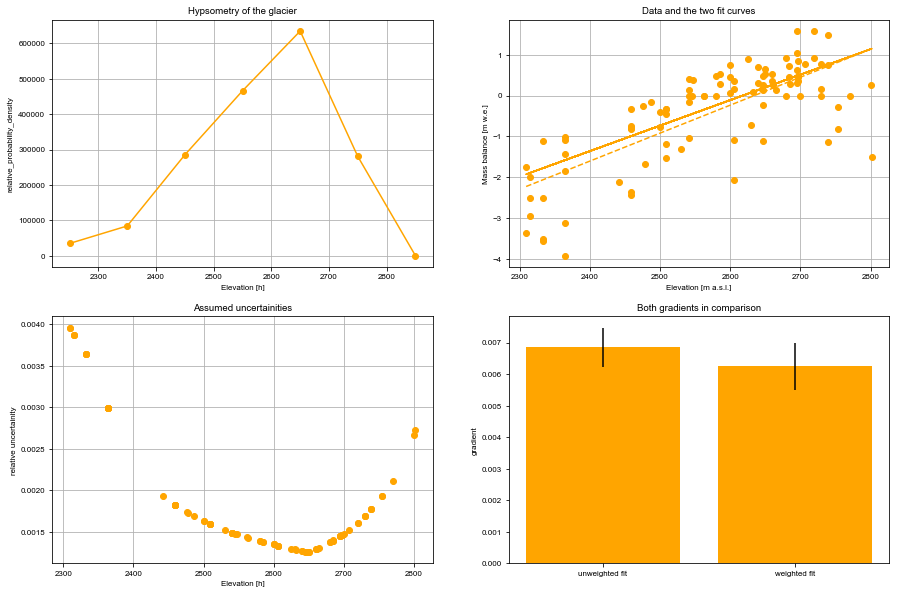

In [87]:
analyse(hypso_kokanee, kokanee_data, 'orange')

### Illecilewaet Glacier 

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


The MB-gradient (unweighted) is:  0.010896927883652908  +-  0.0005365082378874345 
 The MB-gradient (weighted) is:  0.010206092024018861  +-  0.0008089891393687936


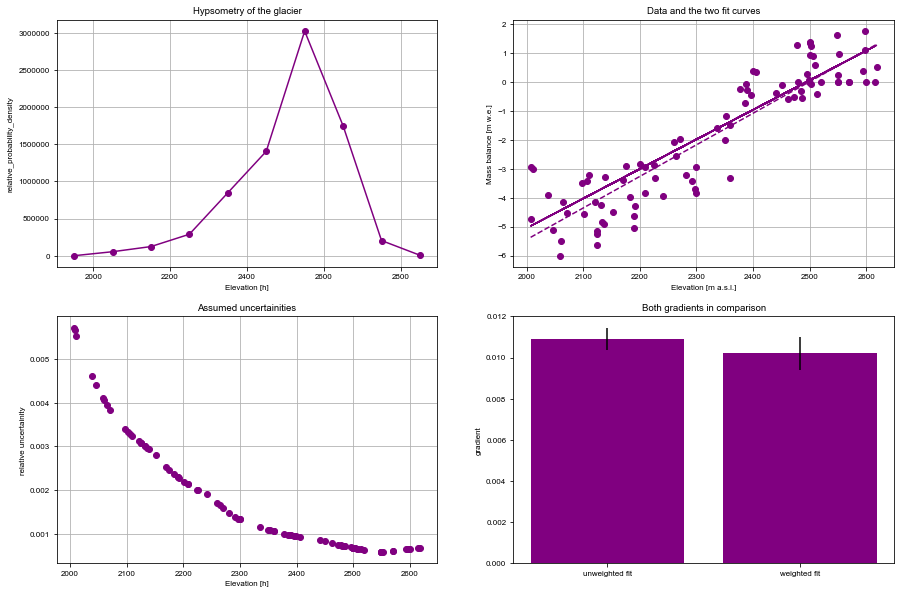

In [88]:
analyse(hypso_ille, ille_data, 'purple')

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


The MB-gradient (unweighted) is:  0.007188315940961024  +-  0.0002466356102654803 
 The MB-gradient (weighted) is:  0.0067531943269702605  +-  0.0003369141162644035


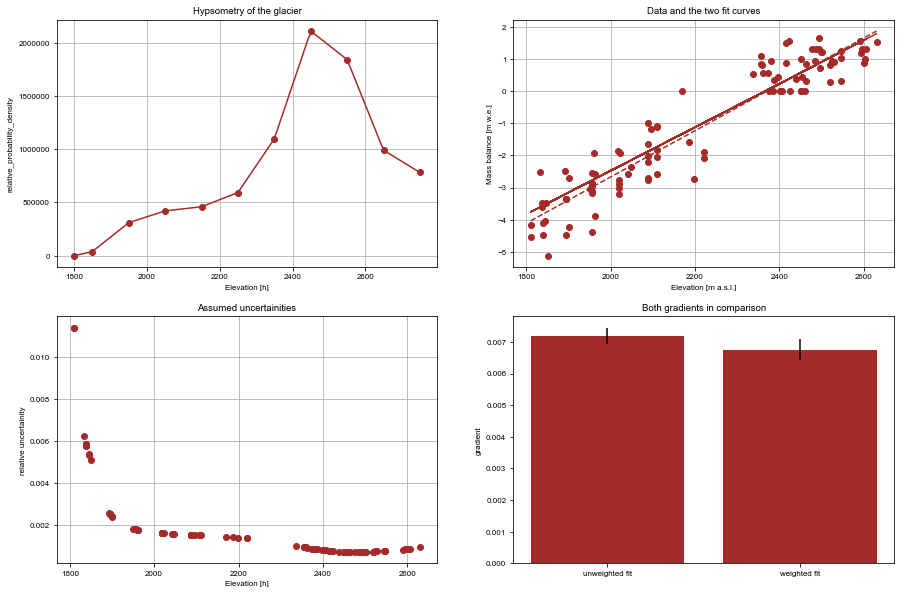

In [89]:
analyse(hypso_castle, castle_data, 'brown')

## Total plot with unweighted fit

not much physical basis for weighting in the manner tried above, so we use unweighted values

the net gradient is:            6.48  +/-  0.2 m w.e. m-1
the net gradient w/o illec is:  6.64  +/-  0.25 m w.e. m-1
the net gradient w/o castle is:  7.25  +/-  0.23 m w.e. m-1
slope gradient: 0.006482    intercept: -16.514474   R-squared: 0.657453 p-value: 2.9916097656037175e-134
sloperadient w/o illec: 0.006637    intercept: -17.068112   R-squared: 0.654541 p-value: 5.850289576374211e-90
slope gradient w/o castle: 0.007250    intercept: -18.617169   R-squared: 0.687433 p-value: 2.9126050478214843e-120
[-1.63825856e+01  6.43437145e-03]
slope RLM: 6.43  +/-  0.21


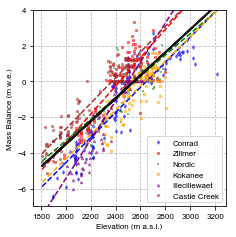

In [90]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [3.34, 3.34] #[7.04, 6.04]
    #JoG figure reqs: (maximum widths: 85 mm single-column; 179 mm double-column) or 3.34 and 7.04 in
s=2.5
alpha = 0.5
plt.plot(conrad_data[0],conrad_data[1],marker='d', markersize=s, linestyle='', color='blue', label='Conrad', alpha=alpha)
plt.plot(zillmer_data[0],zillmer_data[1],marker='s', markersize=s, linestyle='', color='red', label='Zillmer', alpha=alpha)
plt.plot(nordic_data[0],nordic_data[1],marker='+', markersize=s, markeredgewidth=2., linestyle='', color='green', label='Nordic', alpha=alpha)
plt.plot(kokanee_data[0],kokanee_data[1],marker='o', markersize=s, linestyle='', color='orange', label='Kokanee', alpha=alpha)
plt.plot(ille_data[0],ille_data[1],marker='^', markersize=s, linestyle='', color='purple', label='Illecillewaet', alpha=alpha)
plt.plot(castle_data[0],castle_data[1],marker='p', markersize=s, linestyle='', color='brown', label='Castle Creek', alpha=alpha)

x_data_fit=np.linspace(np.min(combined_x_data),np.max(combined_x_data),1000)
x_data_fit2=np.linspace(np.min(combined_x_data2),np.max(combined_x_data2),1000)
x_data_fit3=np.linspace(np.min(combined_x_data3),np.max(combined_x_data3),1000)


print('the net gradient is:           ', np.round(fit(x_data_fit, combined_x_data,combined_y_data)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit, combined_x_data,combined_y_data)[4]*1000,2), 'm w.e. m-1')
print('the net gradient w/o illec is: ', np.round(fit(x_data_fit2, combined_x_data2,combined_y_data2)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit2, combined_x_data2,combined_y_data2)[4]*1000,2), 'm w.e. m-1')
print('the net gradient w/o castle is: ', np.round(fit(x_data_fit3, combined_x_data3,combined_y_data3)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit3, combined_x_data3,combined_y_data3)[4]*1000,2), 'm w.e. m-1')
# print('the net gradient r2 value is:', 'at p-value:',)

slope, intercept, r_value, p_value, std_err = stats.linregress(combined_x_data,combined_y_data)
print("slope gradient: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2,  'p-value:', p_value)
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_x_data2,combined_y_data2)
print("sloperadient w/o illec: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2,  'p-value:', p_value)
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_x_data3,combined_y_data3)
print("slope gradient w/o castle: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2,  'p-value:', p_value)

#plot lines of best fit for individual glaciers
plt.plot(x_data_fit, linear_function(fit(x_data_fit, conrad_data[0],conrad_data[1])[0], fit(x_data_fit, conrad_data[0],conrad_data[1])[1], x_data_fit), color='blue', linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, zillmer_data[0], zillmer_data[1])[0], fit(x_data_fit, zillmer_data[0], zillmer_data[1])[1], x_data_fit), color='red', linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, nordic_data[0],nordic_data[1])[0], fit(x_data_fit, nordic_data[0],nordic_data[1])[1], x_data_fit), color='green',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, kokanee_data[0],kokanee_data[1])[0], fit(x_data_fit, kokanee_data[0],kokanee_data[1])[1], x_data_fit), color='orange',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, ille_data[0],ille_data[1])[0],fit(x_data_fit, ille_data[0],ille_data[1])[1], x_data_fit), color='purple',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, castle_data[0],castle_data[1])[0],fit(x_data_fit, castle_data[0],castle_data[1])[1], x_data_fit), color='brown',linestyle='--', linewidth=1.5)

#plot lines of best fit for all points
# plt.plot(x_data_fit, linear_function(fit(x_data_fit, combined_x_data,combined_y_data)[0], fit(x_data_fit, combined_x_data,combined_y_data)[1], x_data_fit), color='black', linewidth=2., label='Basin grad.')
# plt.plot(x_data_fit2, linear_function(fit(x_data_fit2, combined_x_data2,combined_y_data2)[0], fit(x_data_fit2, combined_x_data2,combined_y_data2)[1], x_data_fit2), color='black', linewidth=2., label='CB less Illec.')
# plt.fill_between(x_data_fit, y-0.25, y+0.25)

#################### RLM  https://www.statsmodels.org/stable/rlm.html
###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
x=np.array(combined_x_data)
y=np.array(combined_y_data)
exog = stm.add_constant(x) #obs_data.Elev)
rlm_model = stm.RLM(y,exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
rlm_results = rlm_model.fit()
stdE=rlm_results.bse[1]
print(rlm_results.params)
plt.plot(x,rlm_results.params[1]*x+rlm_results.params[0], color='k',label='', alpha=0.9, 
        linewidth=2.0, zorder=3) # linestyle='--'
print('slope RLM:', np.round(1000*rlm_results.params[1],2), ' +/- ' , np.round(1000*stdE,2))
################# RLM #################################

plt.ylim(-7,4)
plt.xlabel('Elevation (m a.s.l.)')
plt.ylabel('Mass Balance (m w.e.)')
plt.rcParams["figure.figsize"] = [7,5]
plt.tight_layout()
plt.legend(loc=4)
plt.grid(True, linestyle='--', alpha=0.85)
plt.savefig('/home/pelto/Desktop/lidar_cbt_analysis/Ba/products/all_gradients.pdf', dpi=300)

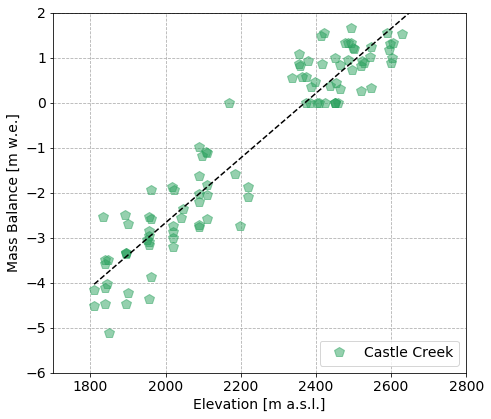

In [91]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [7.04, 6.04]
    #JoG figure reqs: (maximum widths: 85 mm single-column; 179 mm double-column) or 3.34 and 7.04 in

alpha = 0.5

plt.plot(castle_data[0],castle_data[1],marker='p', markersize=10., linestyle='', color='#2ca25f', label='Castle Creek', alpha=alpha)

plt.plot(x_data_fit, linear_function(fit(x_data_fit, castle_data[0],castle_data[1])[0],fit(x_data_fit, castle_data[0],castle_data[1])[1], x_data_fit), color='k',linestyle='--', linewidth=1.5)


plt.ylim(-6,2)
plt.xlim(1700,2800)
plt.xlabel('Elevation [m a.s.l.]')
plt.ylabel('Mass Balance [m w.e.]')
plt.rcParams["figure.figsize"] = [7,5]
plt.tight_layout()
plt.legend(loc=4)
plt.grid(True, linestyle='--')
plt.savefig('/home/pelto/Desktop/lidar_cbt_analysis/Ba/products/castle_gradient.png', dpi=300)